In [1]:
# Import relevant libraries
import pandas as pd
from apyori import apriori
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
from collections import defaultdict
import subprocess
import re

<h2>Part 1: Association mining to find common items purchased based on online retail data</h2>

A European online retail store has recorded the purchase history of its customers. The online retail data D1.csv consists of 19,663 observations where each observation presents an item purchased in the invoice. The data also contains other attributes such as quantity and unit price. There is a total of 10156 unique purchases (invoices) and 13 unique items purchased.

<h3>Data Pre-processing</h3>

In [2]:
# Load the online retail store dataset
retail_data = pd.read_csv('D1.csv')

# Get summary of dataset
retail_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19663 entries, 0 to 19662
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   InvoiceNo    19663 non-null  int64  
 1   StockCode    19663 non-null  object 
 2   Description  19075 non-null  object 
 3   Quantity     19663 non-null  int64  
 4   InvoiceDate  19663 non-null  object 
 5   UnitPrice    19663 non-null  float64
 6   CustomerID   15678 non-null  float64
 7   Country      19663 non-null  object 
dtypes: float64(2), int64(2), object(4)
memory usage: 1.2+ MB


In [3]:
# Check first 10 rows
retail_data.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,1/12/2010 8:26,2.55,17850.0,United Kingdom
1,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,1/12/2010 8:34,1.69,13047.0,United Kingdom
2,536373,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,1/12/2010 9:02,2.55,17850.0,United Kingdom
3,536375,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,1/12/2010 9:32,2.55,17850.0,United Kingdom
4,536378,22386,JUMBO BAG PINK POLKADOT,10,1/12/2010 9:37,1.95,14688.0,United Kingdom
5,536378,20725,LUNCH BAG RED RETROSPOT,10,1/12/2010 9:37,1.65,14688.0,United Kingdom
6,536378,21212,PACK OF 72 RETROSPOT CAKE CASES,120,1/12/2010 9:37,0.42,14688.0,United Kingdom
7,536384,22457,NATURAL SLATE HEART CHALKBOARD,12,1/12/2010 9:53,2.95,18074.0,United Kingdom
8,536384,22469,HEART OF WICKER SMALL,40,1/12/2010 9:53,1.45,18074.0,United Kingdom
9,536386,85099B,JUMBO BAG RED RETROSPOT,100,1/12/2010 9:57,1.65,16029.0,United Kingdom


In [4]:
# Convert InvoiceDate variable to DateTime datatype. All others are correct
retail_data['InvoiceDate'] = pd.to_datetime(retail_data['InvoiceDate'], dayfirst=True)

# Check it has worked
retail_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19663 entries, 0 to 19662
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   InvoiceNo    19663 non-null  int64         
 1   StockCode    19663 non-null  object        
 2   Description  19075 non-null  object        
 3   Quantity     19663 non-null  int64         
 4   InvoiceDate  19663 non-null  datetime64[ns]
 5   UnitPrice    19663 non-null  float64       
 6   CustomerID   15678 non-null  float64       
 7   Country      19663 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(2), object(3)
memory usage: 1.2+ MB


In [5]:
# Check the unique values for each variable
retail_data['StockCode'].value_counts()

StockCode
85123A    2260
85099B    2115
22423     2019
47566     1707
20725     1594
          ... 
21279        1
21278        1
84741C       1
84507B       1
85175        1
Name: count, Length: 436, dtype: int64

In [6]:
# StockCode has more values than the expected 13.
# Count how many unique values in the StockCode variable
retail_data['StockCode'].nunique()

436

In [7]:
# Look at the description of all StockCodes
retail_data.groupby(['StockCode', 'Description']).count()

,,InvoiceNo,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
StockCode,Description,,,,,,
20725,LUNCH BAG RED RETROSPOT,1594,1594,1594,1594,1316,1594
20727,LUNCH BAG BLACK SKULL.,1328,1328,1328,1328,1105,1328
21212,PACK OF 72 RETROSPOT CAKE CASES,1370,1370,1370,1370,1068,1370
22386,JUMBO BAG PINK POLKADOT,1238,1238,1238,1238,890,1238
22423,REGENCY CAKESTAND 3 TIER,2019,2019,2019,2019,1724,2019
22457,NATURAL SLATE HEART CHALKBOARD,1263,1263,1263,1263,980,1263
22469,HEART OF WICKER SMALL,1226,1226,1226,1226,985,1226
22720,SET OF 3 CAKE TINS PANTRY DESIGN,1399,1399,1399,1399,1159,1399
47566,PARTY BUNTING,1707,1707,1707,1707,1397,1707


All of the extra `StockCode` values (422 of them) do not have a Description.

In [8]:
# Remove all rows that have missing value in the Description column
retail_data.dropna(subset = ['Description'], inplace=True)

# Check it has worked
retail_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19075 entries, 0 to 19662
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   InvoiceNo    19075 non-null  int64         
 1   StockCode    19075 non-null  object        
 2   Description  19075 non-null  object        
 3   Quantity     19075 non-null  int64         
 4   InvoiceDate  19075 non-null  datetime64[ns]
 5   UnitPrice    19075 non-null  float64       
 6   CustomerID   15678 non-null  float64       
 7   Country      19075 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(2), object(3)
memory usage: 1.3+ MB


In [9]:
# Check the values for the StockCode variable
retail_data['StockCode'].value_counts()

StockCode
85123A    2260
85099B    2115
22423     2019
47566     1707
20725     1594
84879     1489
22720     1399
21212     1370
20727     1328
22457     1263
22386     1238
22469     1226
85123a      67
Name: count, dtype: int64

There is still the issue of inconsistent data for the 'White hanging heart t-light holder'. There are 2 StockCodes for this item: 85123A and 85123a

In [10]:
# Replace the StockCode value 85123a with 85123A
retail_data['StockCode'].replace(to_replace='85123a', value='85123A', inplace=True)

# Check if it worked
retail_data['StockCode'].value_counts()

StockCode
85123A    2327
85099B    2115
22423     2019
47566     1707
20725     1594
84879     1489
22720     1399
21212     1370
20727     1328
22457     1263
22386     1238
22469     1226
Name: count, dtype: int64

In [11]:
# Create table of stock codes and descriptions for reference
retail_data.groupby(['StockCode', 'Description']).count()

,,InvoiceNo,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
StockCode,Description,,,,,,
20725,LUNCH BAG RED RETROSPOT,1594,1594,1594,1594,1316,1594
20727,LUNCH BAG BLACK SKULL.,1328,1328,1328,1328,1105,1328
21212,PACK OF 72 RETROSPOT CAKE CASES,1370,1370,1370,1370,1068,1370
22386,JUMBO BAG PINK POLKADOT,1238,1238,1238,1238,890,1238
22423,REGENCY CAKESTAND 3 TIER,2019,2019,2019,2019,1724,2019
22457,NATURAL SLATE HEART CHALKBOARD,1263,1263,1263,1263,980,1263
22469,HEART OF WICKER SMALL,1226,1226,1226,1226,985,1226
22720,SET OF 3 CAKE TINS PANTRY DESIGN,1399,1399,1399,1399,1159,1399
47566,PARTY BUNTING,1707,1707,1707,1707,1397,1707


<h3>Association Analysis</h3>

Text(0.5, 0, 'StockCode')

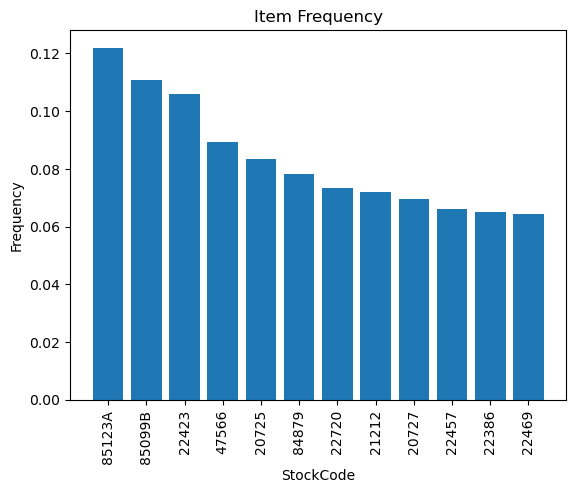

In [12]:
# Want to understand the frequency of each StockCode to help inform an initial minimum support threshold
item_freq=retail_data['StockCode'].value_counts(normalize=True) # Calculate the frequency of each stock code through value counts
x = item_freq.index.tolist() # Convert the stock code values to a list
data = item_freq.tolist() # Convert the frequencies to a list

plt.bar(x, data)
plt.title('Item Frequency') # Set a title for sub-plot
plt.xticks(rotation =90) # Rotate labels so they can be seen
plt.ylabel('Frequency')
plt.xlabel('StockCode')


In [13]:
# To prepare the data for association analysis, group by InvoiceNo (the transaction), then list all items (by StockCode) for that invoice
transactions = retail_data.groupby(['InvoiceNo'])['StockCode'].apply(list)

# Check the output
print(transactions.head(10))

InvoiceNo
536365                 [85123A]
536367                  [84879]
536373                 [85123A]
536375                 [85123A]
536378    [22386, 20725, 21212]
536384           [22457, 22469]
536386                 [85099B]
536388                  [22469]
536390         [85123A, 85099B]
536392                  [84879]
Name: StockCode, dtype: object


In [14]:
# Convert the transactions from pandas into normal list format 
transaction_list = list(transactions)
# Run apriori with a minimum support of 0.01 to start with
results_01 = list(apriori(transaction_list, min_support=0.01, min_confidence=0.5))

# print first 5 rules
# print(results_05[:5])

In [15]:
# Convert the transactions from pandas into normal list format 
transaction_list = list(transactions)
# Run apriori with a minimum support of 0.1 to start with
results_05 = list(apriori(transaction_list, min_support=0.05, min_confidence=0.1))

# print first 5 rules
print(results_05[:5])

[RelationRecord(items=frozenset({'20725'}), support=0.16346153846153846, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'20725'}), confidence=0.16346153846153846, lift=1.0)]), RelationRecord(items=frozenset({'20727'}), support=0.13304765886287626, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'20727'}), confidence=0.13304765886287626, lift=1.0)]), RelationRecord(items=frozenset({'21212'}), support=0.13795986622073578, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'21212'}), confidence=0.13795986622073578, lift=1.0)]), RelationRecord(items=frozenset({'22386'}), support=0.12729933110367894, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'22386'}), confidence=0.12729933110367894, lift=1.0)]), RelationRecord(items=frozenset({'22423'}), support=0.2078804347826087, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'22423

In [16]:
# Convert the transactions from pandas into normal list format 
transaction_list = list(transactions)
# Run apriori with a minimum support of 0.1 to start with
results_025 = list(apriori(transaction_list, min_support=0.025, min_confidence=0.1))

# print first 5 rules
print(results_025[:5])

[RelationRecord(items=frozenset({'20725'}), support=0.16346153846153846, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'20725'}), confidence=0.16346153846153846, lift=1.0)]), RelationRecord(items=frozenset({'20727'}), support=0.13304765886287626, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'20727'}), confidence=0.13304765886287626, lift=1.0)]), RelationRecord(items=frozenset({'21212'}), support=0.13795986622073578, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'21212'}), confidence=0.13795986622073578, lift=1.0)]), RelationRecord(items=frozenset({'22386'}), support=0.12729933110367894, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'22386'}), confidence=0.12729933110367894, lift=1.0)]), RelationRecord(items=frozenset({'22423'}), support=0.2078804347826087, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'22423

In [17]:
# Create a function to convert the results to a dataframe. Function is that shown in Module 5 of the coursework.
def convert_apriori_results_to_pandas_df(results):
    rules = []
    
    for rule_set in results:
        for rule in rule_set.ordered_statistics:
            # items_base = left side of rules, items_add = right side
            # support, confidence and lift for respective rules
            rules.append([','.join(rule.items_base), ','.join(rule.items_add),
                         rule_set.support, rule.confidence, rule.lift]) 
    
    # typecast it to pandas df
    return pd.DataFrame(rules, columns=['Left_side', 'Right_side', 'Support', 'Confidence', 'Lift']) 



In [18]:
# Run the function and show the first 20 rows
result_01_df = convert_apriori_results_to_pandas_df(results_01)

result_01_df.sort_values(by='Lift', ascending=False)
# result_01_df.info()
# print(result_01_df.head(20))

,Left_side,Right_side,Support,Confidence,Lift
32,"85099B,20727,22386",20725,0.013064,0.690608,4.224894
30,"20727,20725,85099B",22386,0.013064,0.531915,4.178458
13,"20727,22423",21212,0.013587,0.550847,3.992809
7,"20727,85099B",20725,0.024561,0.625000,3.823529
4,"20725,22423",20727,0.014528,0.503623,3.785284
9,"20725,22423",21212,0.015050,0.521739,3.781818
31,"85099B,20725,22386",20727,0.013064,0.502008,3.773144
2,"20727,21212",20725,0.017977,0.616487,3.771453
3,"20727,22386",20725,0.016409,0.613281,3.751838
14,"47566,20727",21212,0.013482,0.513944,3.725317


In [19]:
# Run the function and show the first 20 rows
result_05_df = convert_apriori_results_to_pandas_df(results_05)

result_05_df.sort_values(by='Lift', ascending=False)

# print(result_df.head(20))

,Left_side,Right_side,Support,Confidence,Lift
17,85099B,22386,0.086225,0.394359,3.097891
16,22386,85099B,0.086225,0.677340,3.097891
13,20727,20725,0.066994,0.503535,3.080449
12,20725,20727,0.066994,0.409847,3.080449
15,85099B,20725,0.060514,0.276769,1.693173
14,20725,85099B,0.060514,0.370205,1.693173
1,,20727,0.133048,0.133048,1.000000
11,,85123A,0.236204,0.236204,1.000000
10,,85099B,0.218645,0.218645,1.000000
0,,20725,0.163462,0.163462,1.000000


In [20]:
# Run the function and show the first 20 rows
# result_1_df = convert_apriori_results_to_pandas_df(results_1)

# result_1_df.sort_values(by='Lift', ascending=False)

# print(result_df.head(20))

In [21]:
# Run the function and show the first 20 rows
result_025_df = convert_apriori_results_to_pandas_df(results_025)

result_025_df.sort_values(by='Lift', ascending=False).head(20)

# print(result_025_df.head(20))

,Left_side,Right_side,Support,Confidence,Lift
89,"20725,22386",85099B,0.026024,0.770898,3.525789
88,85099B,"20725,22386",0.026024,0.119025,3.525789
90,"20725,85099B",22386,0.026024,0.430052,3.378272
87,22386,"20725,85099B",0.026024,0.204433,3.378272
46,22386,85099B,0.086225,0.677340,3.097891
47,85099B,22386,0.086225,0.394359,3.097891
12,20725,20727,0.066994,0.409847,3.080449
13,20727,20725,0.066994,0.503535,3.080449
60,22457,22469,0.031041,0.237790,1.894402
61,22469,22457,0.031041,0.247294,1.894402


In [22]:
# Decided to use the settings of minimimum support value = 0.01, minimum confidence = 0.5

Identify top-5 common items that customers have purchased along with ‘LUNCH BAG RED RETROSPOT’.

In [23]:
# To identify common items purchased with LUNCH BAG RED RETROSPOT, will filter the dataframe to only show rows with stock code 20725: LUNCH BAG RED RETROSPOT 	
red_spot_df = result_01_df[result_01_df['Left_side'].str.contains("20725")]

In [24]:
red_spot_df.sort_values(by='Support', ascending=False)

,Left_side,Right_side,Support,Confidence,Lift
10,"20725,22386",85099B,0.026024,0.770898,3.525789
9,"20725,22423",21212,0.015050,0.521739,3.781818
4,"20725,22423",20727,0.014528,0.503623,3.785284
11,"20725,22457",85099B,0.013273,0.582569,2.664445
29,"20727,20725,22386",85099B,0.013064,0.796178,3.641412
30,"20727,20725,85099B",22386,0.013064,0.531915,4.178458
31,"85099B,20725,22386",20727,0.013064,0.502008,3.773144
12,"20725,22469",85099B,0.011079,0.546392,2.498985


<h3>Sequence Analysis</h3>

In [25]:
# Will now complete sequence analysis on the same dataset
# Can do this because we know the date and time of each transaction
# First need to sort the data by the date so it is in order
retail_data_sorted = retail_data.sort_values(by='InvoiceDate')

# Check that sorted correctly
retail_data_sorted

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom
2,536373,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 09:02:00,2.55,17850.0,United Kingdom
3,536375,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 09:32:00,2.55,17850.0,United Kingdom
4,536378,22386,JUMBO BAG PINK POLKADOT,10,2010-12-01 09:37:00,1.95,14688.0,United Kingdom
...,...,...,...,...,...,...,...,...
19659,581538,20725,LUNCH BAG RED RETROSPOT,1,2011-12-09 11:34:00,1.65,14446.0,United Kingdom
19657,581538,22469,HEART OF WICKER SMALL,1,2011-12-09 11:34:00,1.65,14446.0,United Kingdom
19660,581579,22386,JUMBO BAG PINK POLKADOT,10,2011-12-09 12:19:00,1.79,17581.0,United Kingdom
19661,581583,20725,LUNCH BAG RED RETROSPOT,40,2011-12-09 12:23:00,1.45,13777.0,United Kingdom


In [26]:
# Now prepare the data for sequence analysis, group by InvoiceNo (the transaction), then list all items (by StockCode) for that invoice
# Should now be in the order of invoice date
transactions2 = retail_data_sorted.groupby(['InvoiceNo'])['StockCode'].apply(list)
sequences = transactions2.values.tolist()
# Check the output
print(sequences[:5])

[['85123A'], ['84879'], ['85123A'], ['85123A'], ['22386', '20725', '21212']]


In [27]:
sequences

[['85123A'],
 ['84879'],
 ['85123A'],
 ['85123A'],
 ['22386', '20725', '21212'],
 ['22457', '22469'],
 ['85099B'],
 ['22469'],
 ['85123A', '85099B'],
 ['84879'],
 ['85123A'],
 ['21212', '84879'],
 ['85123A'],
 ['85123A', '20725'],
 ['22469', '21212', '20727'],
 ['85123A'],
 ['84879', '21212'],
 ['85099B'],
 ['20727', '20725'],
 ['22469', '21212'],
 ['84879'],
 ['21212', '84879', '21212', '85099B', '22386'],
 ['22423'],
 ['84879', '85123A', '22423'],
 ['22469', '22469', '85123A'],
 ['85099B'],
 ['22423'],
 ['85099B'],
 ['22423'],
 ['22423'],
 ['21212'],
 ['84879'],
 ['22423'],
 ['22469', '22457'],
 ['22423'],
 ['20727', '22386', '85099B', '85123A'],
 ['22423', '22457', '22469', '85099B', '85123A', '20725', '21212'],
 ['22423'],
 ['22457'],
 ['22469'],
 ['85123A', '85099B'],
 ['85099B', '85123A', '20727'],
 ['20725'],
 ['20727'],
 ['85099B'],
 ['85123A', '22457'],
 ['22386'],
 ['85099B',
  '84879',
  '22469',
  '22423',
  '20727',
  '21212',
  '85123A',
  '20725',
  '22386'],
 ['85123A']

In [28]:
''' Uses SPMF to find association rules in supplied transactions '''
def get_association_rules(sequences, min_sup, min_conf):
    # step 1: create required input for SPMF
    
    # prepare a dict to uniquely assign each item in the transactions to an int ID
    item_dict = defaultdict(int)
    output_dict = defaultdict(str)
    item_id = 1
    
    # write your sequences in SPMF format
    with open('seq_rule_input.txt', 'w+') as f:
        for sequence in sequences:
            z = []
            for itemset in sequence:
                # if there are multiple items in one itemset
                if isinstance(itemset, list):
                    for item in itemset:
                        if item not in item_dict:
                            item_dict[item] = item_id
                            item_id += 1

                        z.append(item_dict[item])
                else:
                    if itemset not in item_dict:
                        item_dict[itemset] = item_id
                        output_dict[str(item_id)] = itemset
                        item_id += 1
                    z.append(item_dict[itemset])
                    
                # end of itemset
                z.append(-1)
            
            # end of a sequence
            z.append(-2)
            f.write(' '.join([str(x) for x in z]))
            f.write('\n')
    
    # run SPMF with supplied parameters
    supp_param = '{}%'.format(int(min_sup * 100))
    conf_param = '{}%'.format(int(min_conf * 100))
    subprocess.call(['java', '-jar', 'spmf.jar', 'run', 'RuleGrowth', 'seq_rule_input.txt', 'seq_rule_output.txt', supp_param, conf_param], shell=True)
    
    # read back the output rules
    outputs = open('seq_rule_output.txt', 'r').read().strip().split('\n')
    output_rules = []
    for rule in outputs:
        left, right, sup, conf = re.search(pattern=r'([0-9\,]+) ==> ([0-9\,]+) #SUP: ([0-9]+) #CONF: ([0-9\.]+)', string=rule).groups()
        sup = int(sup) / len(sequences)
        conf = float(conf)
        output_rules.append([[output_dict[x] for x in left.split(',')], [output_dict[x] for x in right.split(',')], sup, conf])
    
    # return pandas DataFrame
    return pd.DataFrame(output_rules, columns = ['Left_rule', 'Right_rule', 'Support', 'Confidence'])

In [29]:
# Now get associations using `min_supp` of 0.02 and `min_conf` of 0.1.
# Started with min_supp of 0.1, but it was too strict and did not return any rules
get_association_rules(sequences, 0.02, 0.1)

,Left_rule,Right_rule,Support,Confidence
0,[85123A],[22457],0.023725,0.100442
1,[22457],[85123A],0.020589,0.157726
2,[22469],[85123A],0.021844,0.174022
3,[85099B],[85123A],0.026129,0.119503
4,[22423],[85123A],0.021008,0.101056
5,[47566],[85123A],0.020903,0.118624
6,[22386],[85099B],0.046823,0.367816
7,[85099B],[22386],0.041179,0.188337
8,[20725],[85099B],0.028637,0.175192
9,[85099B],[20725],0.032295,0.147706


<h2>Part 2: Clustering of COVID-19 Epidemiological data</h2>

The Epidemiological dataset consists of countries’ COVID-19 epidemiological parameter information represented with 9 variables. Each country followed different response strategies (such as early border closes, lockdown, etc.) in containing the spread. This has made COVID-19 spread behave differently in different countries. The epidemiological model on countries based on John Hopkins’s dataset has learned the epidemiological parameters. These parameters inform us of the response behaviour of different countries that followed different response strategies.

You are given two epidemiological datasets representing the epidemiological parameters of countries in March and April 2020 respectively. D2_mar.csv consists of 102 countries and their epidemiological parameters, while D2_apr.csv consists of 118 countries and their epidemiological parameters. The values reported are standardised values of original values.

Suppose you are working as a data analyst in a government agency. Usually, this type of data is used to forecast the spread rate etc. However, in our study we will utilise this data to conduct clustering and understand how various groups of counties are affected by the covid outbreaks over a period of time. You have been given a dataset collected over two months.

<h3>Data Pre-processing</h3>

In [30]:
# Load the 2 covid datasets
covid_march = pd.read_csv('D2_mar.csv')
covid_april = pd.read_csv('D2_apr.csv')

# Get summary of dataset
covid_march.info()
covid_april.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102 entries, 0 to 101
Data columns (total 9 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   residual_transmission               102 non-null    float64
 1   regulatable_transmission            102 non-null    float64
 2   recovery_rate                       102 non-null    float64
 3   detection_rate                      102 non-null    float64
 4   death_rate                          102 non-null    float64
 5   response_slope                      102 non-null    float64
 6   initial_relative_latent_infections  102 non-null    float64
 7   response_weights                    102 non-null    float64
 8   Country                             102 non-null    object 
dtypes: float64(8), object(1)
memory usage: 7.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 9 columns):
 #   Column              

All datatypes seem to have been assigned correctly

In [31]:
# There are 118 countries in the april data set and only 102 in the march dataset
# Identify countries that are in april dataset but not in march dataset
march_countries = covid_march['Country'].unique().tolist() # convert the countries to a list
april_countries = covid_april['Country'].unique().tolist()

april_only = []
for element in april_countries:
    if element not in march_countries:
        april_only.append(element)
 
print(april_only)


['KEN', 'KGZ', 'MDG', 'MLI', 'MNE', 'NER', 'PRY', 'RWA', 'SLV', 'TTO', 'BGD', 'BOL', 'COD', 'DJI', 'GIN', 'GTM']


In [32]:
# There are 16 countries in april and not in march
# Will remove these from the april dataset so that there is 2 months of data for each country
# Otherwise unable to analyse over time

covid_april = covid_april[~covid_april['Country'].isin(april_only)] # Would return true but ~ converts to false
covid_april.info()

<class 'pandas.core.frame.DataFrame'>
Index: 102 entries, 0 to 116
Data columns (total 9 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   residual_transmission               102 non-null    float64
 1   regulatable_transmission            102 non-null    float64
 2   recovery_rate                       102 non-null    float64
 3   detection_rate                      102 non-null    float64
 4   death_rate                          102 non-null    float64
 5   response_slope                      102 non-null    float64
 6   initial_relative_latent_infections  102 non-null    float64
 7   response_weights                    102 non-null    float64
 8   Country                             102 non-null    object 
dtypes: float64(8), object(1)
memory usage: 8.0+ KB


In [33]:
# Check max and min for each variable
covid_april.describe()

# all between 0 and 1

,residual_transmission,regulatable_transmission,recovery_rate,detection_rate,death_rate,response_slope,initial_relative_latent_infections,response_weights
count,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000
mean,0.242817,0.212007,0.231290,0.377844,0.193340,0.543661,0.318544,0.163058
std,0.107012,0.121962,0.224429,0.179760,0.148064,0.132682,0.172783,0.192629
min,0.000000,0.000000,0.000000,0.123911,0.000000,0.000000,0.028617,0.000000
25%,0.165704,0.152637,0.064878,0.254913,0.094269,0.509104,0.216861,0.085056
50%,0.252958,0.195932,0.146925,0.346247,0.147801,0.572325,0.280517,0.118171
75%,0.324293,0.241032,0.330343,0.421719,0.247378,0.622656,0.365696,0.152586
max,0.542288,1.000000,1.000000,1.000000,0.741635,1.000000,1.000000,1.000000


In [34]:
# Check max and min for each variable
covid_march.describe()

# all between 0 and 1

,residual_transmission,regulatable_transmission,recovery_rate,detection_rate,death_rate,response_slope,initial_relative_latent_infections,response_weights
count,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000
mean,0.197575,0.189662,0.153142,0.255073,0.169050,0.327380,0.249317,0.060356
std,0.162790,0.141508,0.171544,0.140229,0.125827,0.094850,0.131924,0.107942
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.109152,0.114929,0.043039,0.185192,0.090103,0.285337,0.175473,0.030672
50%,0.154607,0.147812,0.090012,0.234313,0.136567,0.327628,0.219543,0.043006
75%,0.207843,0.211925,0.184495,0.291991,0.210426,0.365861,0.298990,0.060159
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


ValueError: could not convert string to float: 'ARM'

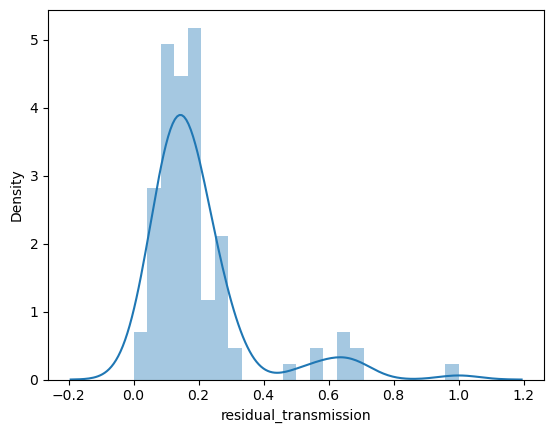

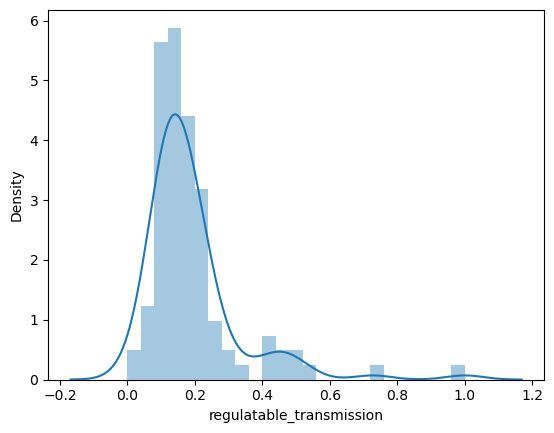

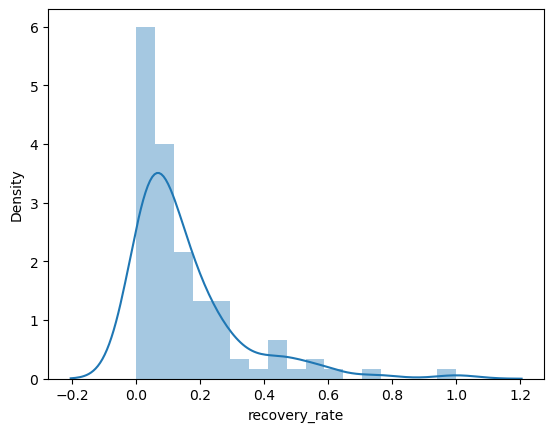

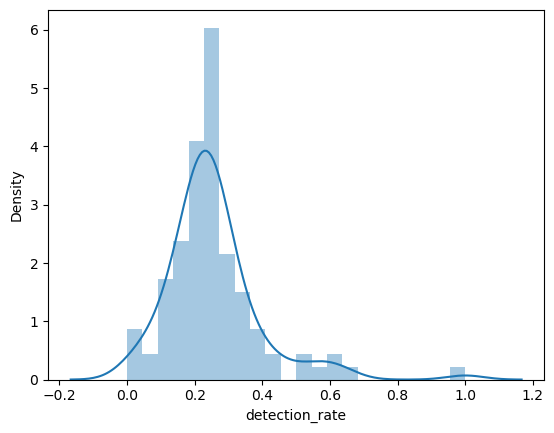

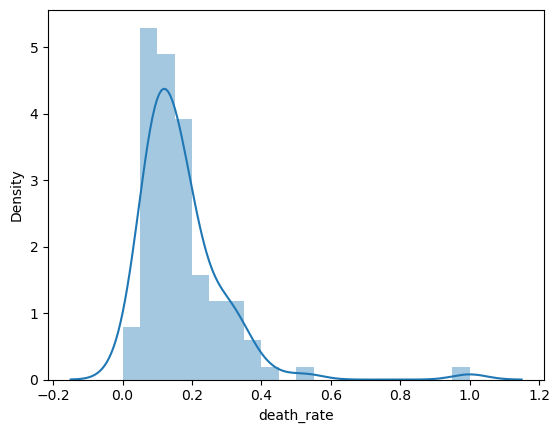

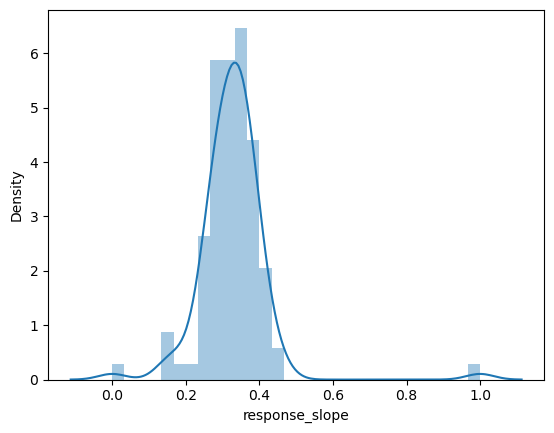

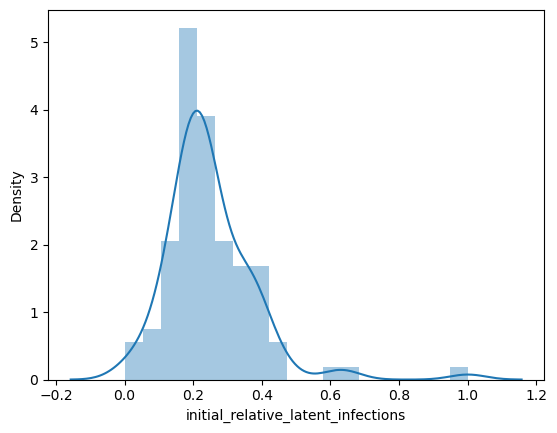

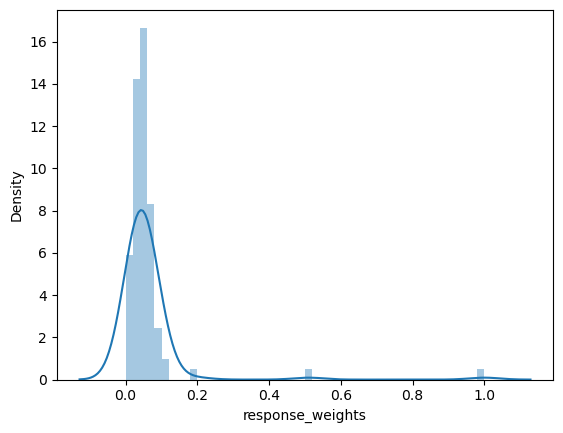

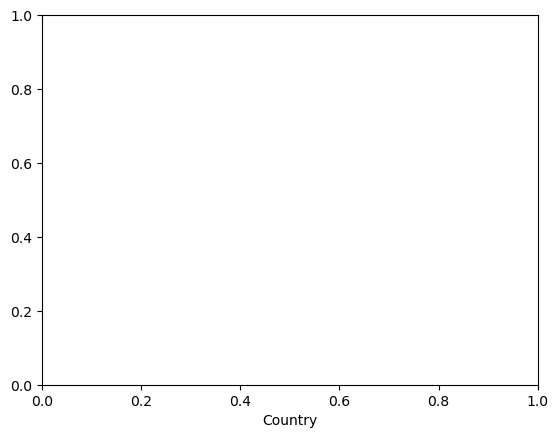

In [35]:
# Check distribution of each variable in March dataset
warnings.filterwarnings("ignore")

for i in covid_march:
    plt.figure() # Create a new figure for each variable
    plt.gca().set(xlabel= i) # Get the current axis for each plot and label x axis with the variable name
    sns.distplot(covid_march[i]) # Generate the histogram for each variable using Seaborn

In [36]:
# Mostly interested in the 4 variables: residual_transmission, recovery_rate, detection_rate, death_rate
# All of these seem to have some outliers with a value of around 1
# Perhaps they all come from the same country
# Show only those rows
covid_march[covid_march['residual_transmission']>0.8]
covid_march[covid_march['regulatable_transmission']>0.8]
covid_march[covid_march['recovery_rate']>0.8]
covid_march[covid_march['detection_rate']>0.8]
covid_march[covid_march['death_rate']>0.8]
covid_march[covid_march['response_slope']>0.8]
covid_march[covid_march['initial_relative_latent_infections']>0.8]

,residual_transmission,regulatable_transmission,recovery_rate,detection_rate,death_rate,response_slope,initial_relative_latent_infections,response_weights,Country
77,0.073591,1.0,0.437286,1.0,0.023123,1.0,1.0,1.0,CHN


ValueError: could not convert string to float: 'ARM'

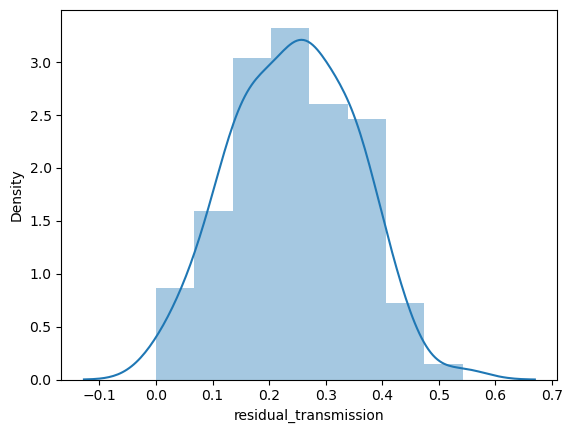

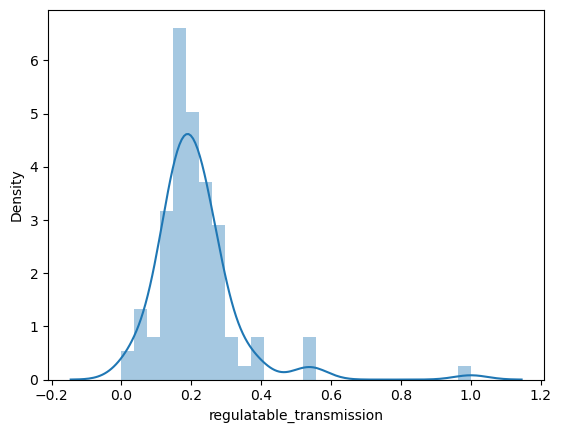

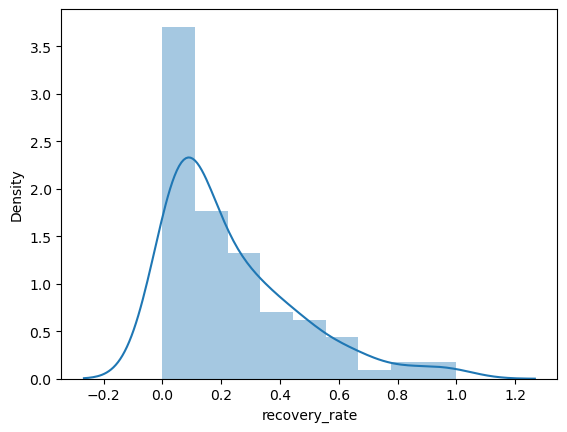

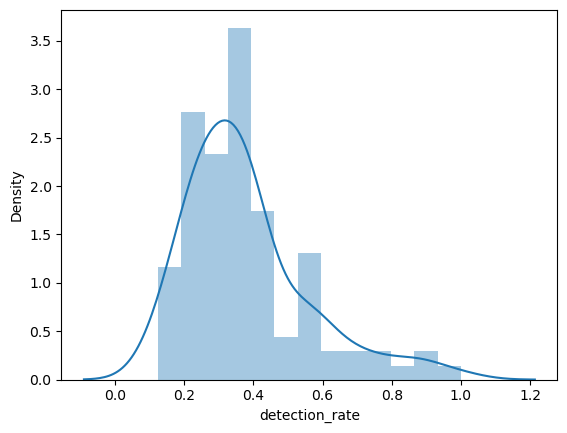

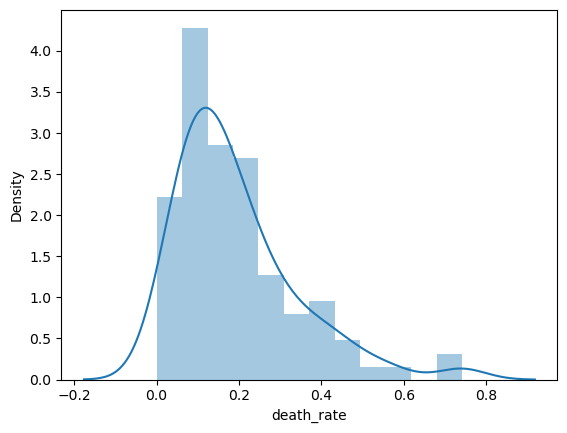

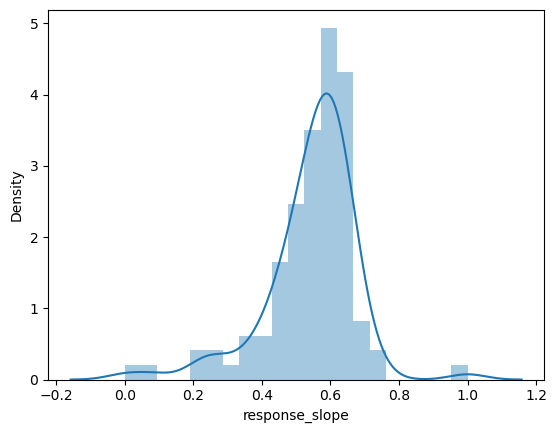

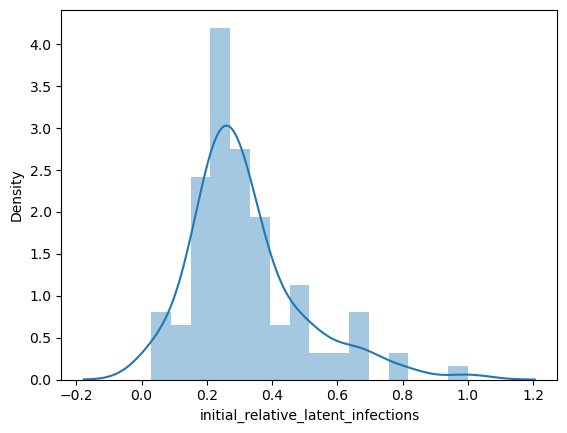

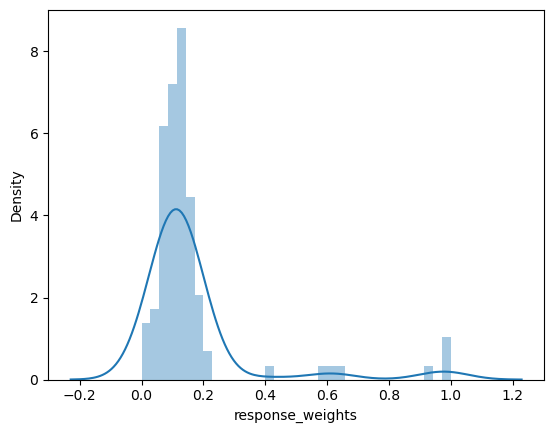

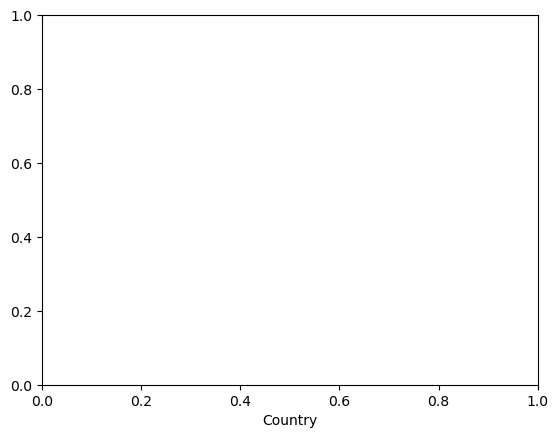

In [37]:
# Check distribution of each variable in April dataset
warnings.filterwarnings("ignore")

for i in covid_april:
    plt.figure() # Create a new figure for each variable
    plt.gca().set(xlabel= i) # Get the current axis for each plot and label x axis with the variable name
    sns.distplot(covid_april[i]) # Generate the histogram for each variable using Seaborn

In [38]:
# Mostly interested in the 4 variables: residual_transmission, recovery_rate, detection_rate, death_rate
# All of these seem to have some outliers with a value of around 1
# Perhaps they all come from the same country
# Show only those rows
covid_april[covid_april['regulatable_transmission']>0.8]
covid_april[covid_april['response_slope']>0.8]

,residual_transmission,regulatable_transmission,recovery_rate,detection_rate,death_rate,response_slope,initial_relative_latent_infections,response_weights,Country
91,0.542288,1.0,0.139325,0.88084,0.024225,1.0,0.660639,1.0,CMR


Distributions look ok. All standardised, doesn't appear to be any values < 0 or > 1 so all theoretically ok.

In [39]:
# Prepare data for clustering by removing redundant variables
# The Agency is only interested in describing the clusters using transmission, recovery, detection, and death rates.
# Can also remove the country variable because clustering works on unlabelled date
# Will remove all other variables from the data sets
covid_march2 = covid_march[['residual_transmission','recovery_rate','detection_rate','death_rate']]
covid_april2 = covid_april[['residual_transmission','recovery_rate','detection_rate','death_rate']]

In [40]:
# Check the new dataframes
covid_march2.info()
covid_april2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102 entries, 0 to 101
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   residual_transmission  102 non-null    float64
 1   recovery_rate          102 non-null    float64
 2   detection_rate         102 non-null    float64
 3   death_rate             102 non-null    float64
dtypes: float64(4)
memory usage: 3.3 KB
<class 'pandas.core.frame.DataFrame'>
Index: 102 entries, 0 to 116
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   residual_transmission  102 non-null    float64
 1   recovery_rate          102 non-null    float64
 2   detection_rate         102 non-null    float64
 3   death_rate             102 non-null    float64
dtypes: float64(4)
memory usage: 4.0 KB


In [41]:
# Convert to a matrix to prepare for clustering
covid_march_X = covid_march2.to_numpy()
covid_april_X = covid_april2.to_numpy()

<h3>Determine optimal number of clusters</h3>

In [42]:
# Use the elbow method for March data
# list to save the clusters and cost
clusters_march = []
inertia_vals_march = []
rs=10


for k in range(2, 15, 1): # Min 2, Max 15, increments of 1
    # train clustering with the specified K
    model_march = KMeans(n_clusters=k, random_state=rs, n_init=10)
    model_march.fit(covid_march_X)
    
    # append model to cluster list
    clusters_march.append(model_march)
    inertia_vals_march.append(model_march.inertia_)

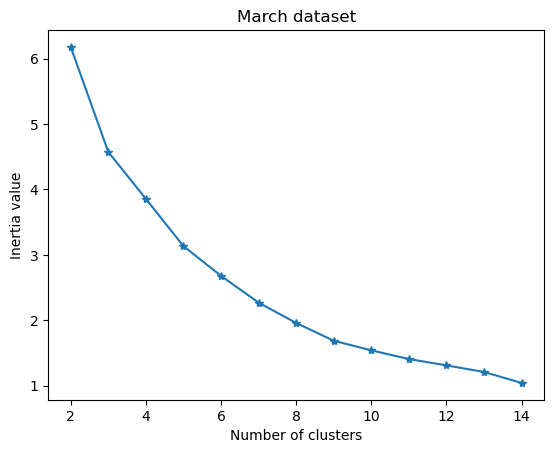

In [43]:
# plot the inertia vs K values
plt.plot(range(2,15,1), inertia_vals_march, marker='*')
plt.ylabel('Inertia value')
plt.xlabel('Number of clusters')
plt.title('March dataset')
plt.show()

In [44]:
# Use the elbow method for April data
# list to save the clusters and cost
clusters_april = []
inertia_vals_april = []
rs=10


for k in range(2, 15, 1): # Min 2, Max 15, increments of 1
    # train clustering with the specified K
    model_april = KMeans(n_clusters=k, random_state=rs, n_init=10)
    model_april.fit(covid_april_X)
    
    # append model to cluster list
    clusters_april.append(model_april)
    inertia_vals_april.append(model_april.inertia_)

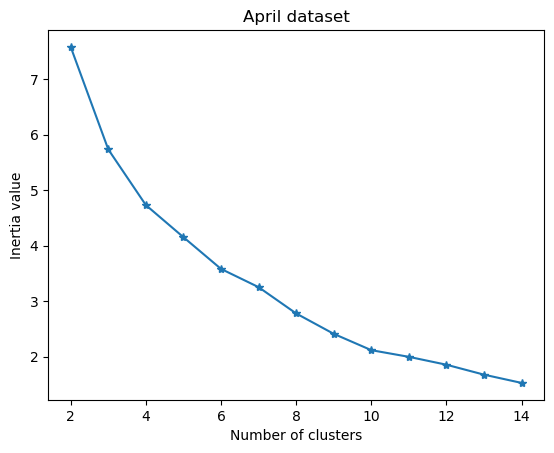

In [45]:
# plot the inertia vs K values
plt.plot(range(2,15,1), inertia_vals_april, marker='*')
plt.ylabel('Inertia value')
plt.xlabel('Number of clusters')
plt.title('April dataset')
plt.show()

In [46]:
# It's not easy to identify the best K value from these plots. 
# Perhaps around 4 or 8 for March, and 7 or 9 for April
# Don't want too many as then the plots becomes more confusing and difficult to interpret.
# Will check silouhette score for a few K values: 3 - 10

# print(clusters_march)
print("March")
print("Silhouette score for k=3", silhouette_score(covid_march_X, clusters_march[2].predict(covid_march_X)))
print("Silhouette score for k=4", silhouette_score(covid_march_X, clusters_march[3].predict(covid_march_X)))
print("Silhouette score for k=5", silhouette_score(covid_march_X, clusters_march[4].predict(covid_march_X)))
print("Silhouette score for k=6", silhouette_score(covid_march_X, clusters_march[5].predict(covid_march_X)))
print("Silhouette score for k=7", silhouette_score(covid_march_X, clusters_march[6].predict(covid_march_X)))
print("Silhouette score for k=8", silhouette_score(covid_march_X, clusters_march[7].predict(covid_march_X)))
print("Silhouette score for k=9", silhouette_score(covid_march_X, clusters_march[8].predict(covid_march_X)))
print("Silhouette score for k=10", silhouette_score(covid_march_X, clusters_march[9].predict(covid_march_X)))

# print(clusters_april[9])
print("April")
print("Silhouette score for k=3", silhouette_score(covid_april_X, clusters_april[2].predict(covid_april_X)))
print("Silhouette score for k=4", silhouette_score(covid_april_X, clusters_april[3].predict(covid_april_X)))
print("Silhouette score for k=5", silhouette_score(covid_april_X, clusters_april[4].predict(covid_april_X)))
print("Silhouette score for k=6", silhouette_score(covid_april_X, clusters_april[5].predict(covid_april_X)))
print("Silhouette score for k=7", silhouette_score(covid_april_X, clusters_april[6].predict(covid_april_X)))
print("Silhouette score for k=8", silhouette_score(covid_april_X, clusters_april[7].predict(covid_april_X)))
print("Silhouette score for k=9", silhouette_score(covid_april_X, clusters_april[8].predict(covid_april_X)))
print("Silhouette score for k=10", silhouette_score(covid_april_X, clusters_april[9].predict(covid_april_X)))


March
Silhouette score for k=3 0.47971886464580304
Silhouette score for k=4 0.4044969742146533
Silhouette score for k=5 0.42443261539960686
Silhouette score for k=6 0.27823807037453385
Silhouette score for k=7 0.30383611106984604
Silhouette score for k=8 0.278453271048621
Silhouette score for k=9 0.28366627099052444
Silhouette score for k=10 0.2803634758138726
April
Silhouette score for k=3 0.3494558741196819
Silhouette score for k=4 0.2746560731394298
Silhouette score for k=5 0.24493466943284317
Silhouette score for k=6 0.23976200682614027
Silhouette score for k=7 0.2657437775019511
Silhouette score for k=8 0.2646998561531366
Silhouette score for k=9 0.2772806980559367
Silhouette score for k=10 0.27320577548041036


In [47]:
# For both March and April, k=3 had the highest silhouette score. 
# Run Kmeans clustering for both the March and April datasets using k=3

# random state
rs = 10

# March
# set the random state. different random state seeds might result in different centroids locations
model_march = KMeans(n_clusters=3, random_state=rs)
model_march.fit(covid_march_X)

model_april = KMeans(n_clusters=3, random_state=rs)
model_april.fit(covid_april_X)

# # sum of intra-cluster distances
# print("Sum of intra-cluster distance:", model.inertia_)

# print("Centroid locations:")
# for centroid in model.cluster_centers_:
#     print(centroid)

KMeans(n_clusters=3, random_state=10)

Cluster membership - March
Cluster_ID
0    71
2    22
1     9
Name: count, dtype: int64


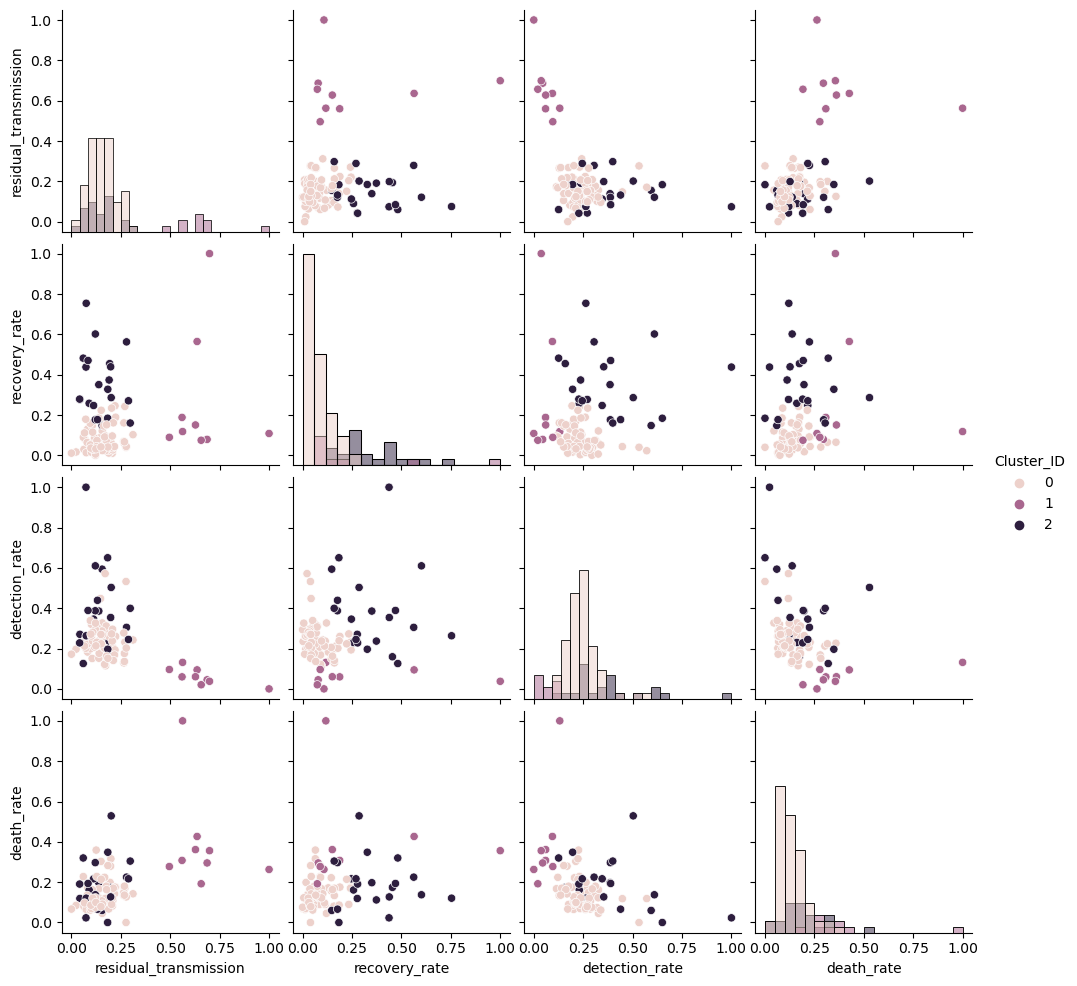

In [48]:
# Now visualise the clustering model for March

# First assign cluster ID to each record in X
# Ignore the warning, does not apply to our case here
y = model_march.predict(covid_march_X)
covid_march2['Cluster_ID'] = y

# how many records are in each cluster
print("Cluster membership - March")
print(covid_march2['Cluster_ID'].value_counts())

# pairplot the cluster distribution.
cluster_march = sns.pairplot(covid_march2, hue='Cluster_ID',diag_kind='hist')
plt.show()

Cluster membership - April
Cluster_ID
1    67
0    19
2    16
Name: count, dtype: int64


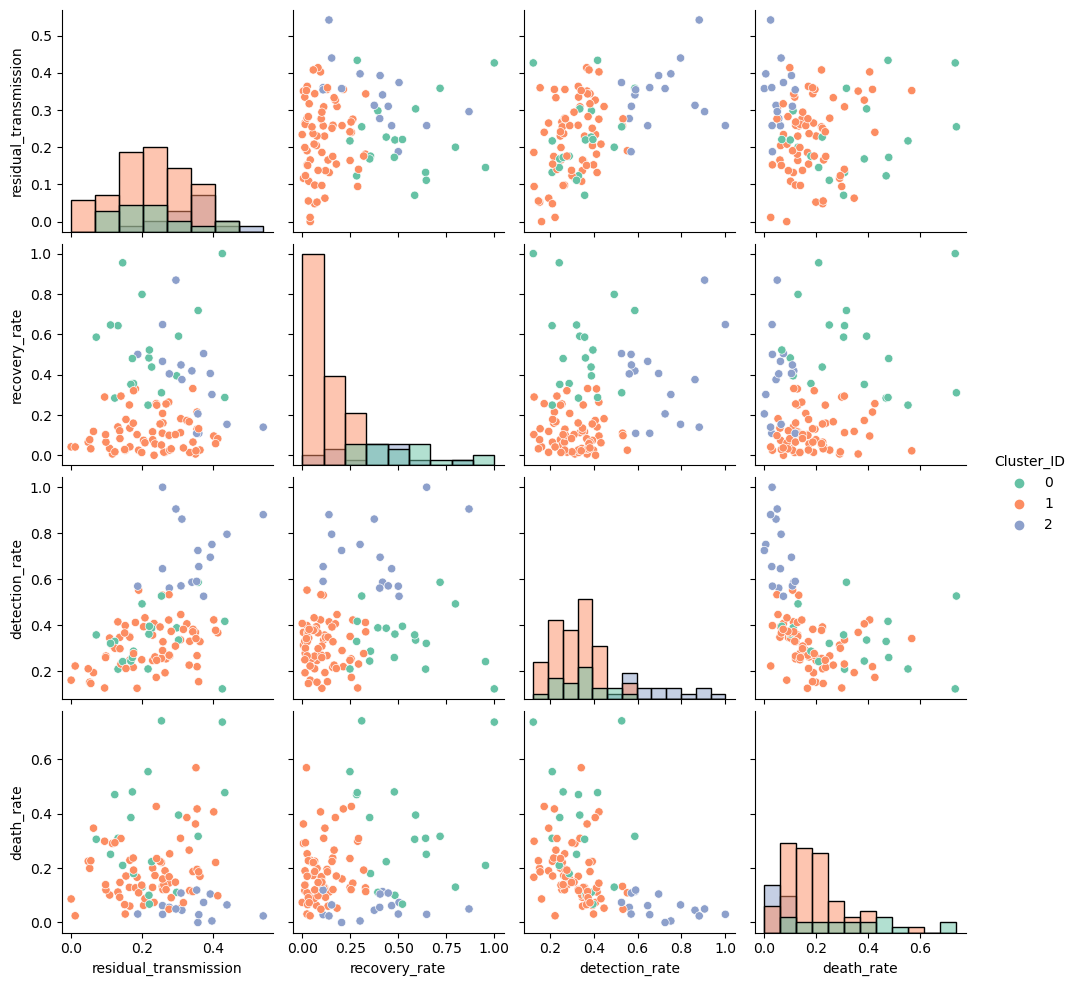

In [49]:
# Now visualise the clustering model for April

# First assign cluster ID to each record in X
# Ignore the warning, does not apply to our case here
y = model_april.predict(covid_april_X)
covid_april2['Cluster_ID'] = y

# how many records are in each cluster
print("Cluster membership - April")
print(covid_april2['Cluster_ID'].value_counts())

# pairplot the cluster distribution.
cluster_april = sns.pairplot(covid_april2, hue='Cluster_ID',diag_kind='hist', palette='Set2')
plt.show()

In [50]:
# Add the cluster number to the original data frame
covid_march3 = covid_march.join(covid_march2['Cluster_ID'])

pd.set_option('display.max_rows', None) # set to display all rows so all variables can be viewed
covid_march3.sort_values(['Cluster_ID','Country'])

,residual_transmission,regulatable_transmission,recovery_rate,detection_rate,death_rate,response_slope,initial_relative_latent_infections,response_weights,Country,Cluster_ID
92,0.108155,0.174913,0.028613,0.280411,0.120637,0.328711,0.162546,0.029372,AND,0
97,0.178046,0.084134,0.151173,0.162166,0.163118,0.322492,0.263635,0.049122,ARE,0
0,0.082074,0.165898,0.129952,0.182487,0.171807,0.246873,0.390325,0.022931,ARM,0
28,0.140443,0.123984,0.085363,0.176300,0.089741,0.196545,0.219781,0.024320,AUS,0
31,0.122192,0.232885,0.054127,0.210169,0.092638,0.289028,0.343179,0.003738,AUT,0
35,0.163879,0.118820,0.144973,0.205859,0.222012,0.262290,0.199817,0.045544,AZE,0
46,0.220609,0.113804,0.245179,0.193306,0.175186,0.327951,0.230302,0.084719,BEL,0
66,0.095639,0.134549,0.051027,0.338881,0.061742,0.374109,0.155942,0.059055,BGR,0
71,0.168170,0.097472,0.090847,0.121645,0.223943,0.267221,0.245292,0.024780,BIH,0
72,0.208185,0.272148,0.036959,0.295779,0.166497,0.265720,0.189090,0.015329,BRA,0


In [51]:
# Add the cluster number to the original data frame
covid_april3 = covid_april.join(covid_april2['Cluster_ID'])

pd.set_option('display.max_rows', None) # set to display all rows so all variables can be viewed
covid_april3.sort_values(['Cluster_ID','Country'])

,residual_transmission,regulatable_transmission,recovery_rate,detection_rate,death_rate,response_slope,initial_relative_latent_infections,response_weights,Country,Cluster_ID
98,0.111187,0.218500,0.645962,0.321537,0.250780,0.612650,0.180373,0.127301,ALB,0
53,0.123131,0.210922,0.283565,0.330012,0.470349,0.416158,0.394714,0.075275,BEL,0
66,0.227337,0.190268,0.437461,0.387583,0.223561,0.649491,0.220544,0.101781,BFA,0
81,0.145540,0.128492,0.954417,0.242356,0.209951,0.669100,0.191227,0.138214,BHR,0
99,0.220899,0.109517,0.521901,0.395920,0.067504,0.228172,0.144763,0.581529,DEU,0
101,0.176046,0.239827,0.355639,0.287685,0.180010,0.638320,0.214770,0.081034,DNK,0
103,0.255018,0.376988,0.309879,0.527327,0.741635,0.590980,0.028617,0.025939,DZA,0
105,0.168643,0.102800,0.351341,0.244756,0.385969,0.646616,0.253087,0.130777,EGY,0
107,0.172876,0.070253,0.479568,0.260136,0.480330,0.480860,0.477510,0.620481,ESP,0
110,0.433839,0.173965,0.286498,0.417401,0.477608,0.354477,0.461567,0.131984,FRA,0


In [52]:
# Join the Cluster ID columns together to easily compare countries that moved clusters
march_countries = covid_march3[['Country','Cluster_ID']]
april_countries = covid_april3[['Country','Cluster_ID']]

march_countries.rename(columns = {'Cluster_ID':'March_cluster'}, inplace = True)
april_countries.rename(columns = {'Cluster_ID':'April_cluster'}, inplace = True)

In [53]:
# Merge into one dataframe
time_comparison = march_countries.merge(april_countries, how='left', on='Country')

time_comparison.to_csv('march_v_april_clusters.csv')